In [3]:
import sys
sys.path.append("..")
import utils.saver as saver
import matplotlib.pyplot as plt
import numpy as np
from qutip.parallel import parfor as parfor
from tqdm import tqdm as tqdm

import system.from_higher_basis_truncation_tunable_full_cosine as system
import pulse.tukey as tukey
import pulse.tanh as tanh
import utils.solver as solver
import utils.expectation_values as expv


# Setup Experimental Data

In [6]:
experimental_data = saver.load_via_pickle("mingkang_data_0.15")

In [7]:
experimental_freqs = experimental_data["freqArray"]
experimental_fids = experimental_data["I_rot.T"]
experimental_time = experimental_data["timeArray"]
experimental_data.keys()

dict_keys(['freqArray', 'ssbArray', 'timeArray', 'Q_rot.T', 'I_rot.T'])

In [8]:
len(experimental_freqs)

91

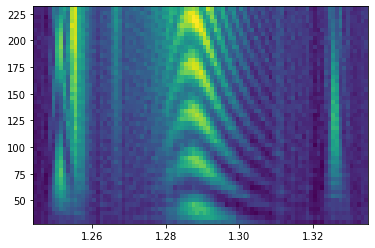

In [9]:
plt.pcolormesh(experimental_freqs, experimental_time, experimental_fids, shading='auto')

In [10]:
# rescale data to 0-1 scale for fidelity
# normalized_experimental_fids = ((experimental_fids - np.amin(experimental_fids)) / np.amax(experimental_fids))
normalized_experimental_fids = ((experimental_fids - np.amin(experimental_fids)))
normalized_experimental_fids /= np.amax(normalized_experimental_fids)

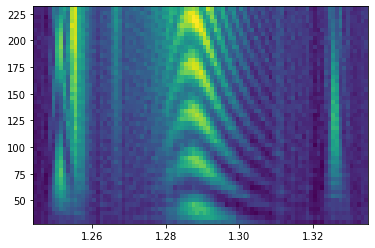

In [11]:
plt.pcolormesh(experimental_freqs, experimental_time, normalized_experimental_fids, shading='auto')
# cool still works

[0.07041023214497229, 0.2307178895754329, 0.4605801290613829, 0.9258326532159632]


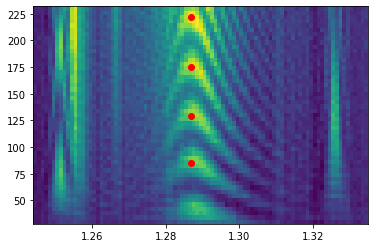

In [12]:
# pick some points to be representative
# we only need to scan over very narrow range around center to get where the chevrons are
freq_points = [1.287, 1.287, 1.287, 1.287]
dur_points = [85, 129, 175, 222]
fid_points = []
for i in range(0, len(dur_points)):
    nearest_freq_index = (np.abs(experimental_freqs - freq_points[i])).argmin()
    nearest_dur_index = (np.abs(experimental_time - dur_points[i])).argmin()
    closest_fidelity = normalized_experimental_fids[nearest_freq_index][nearest_dur_index]
    fid_points.append(closest_fidelity)
plt.pcolormesh(experimental_freqs, experimental_time, normalized_experimental_fids, shading='auto')
plt.scatter(freq_points, dur_points, color='red')
print(fid_points)

# Run Simulations

In [13]:
default_dur = dur_points[0]
default_off = freq_points[0]
_amplitude = None # will be set in function
ramp_slope = 0.5
cut_factor = 3

In [13]:
def vary_offset(off, multiplier=10):
    tlist = np.linspace(0, default_dur, int(default_dur*multiplier))
    tanh.setup(amplitude=_amplitude, drive_frequency= system.first_energy_spacing/3 - off, ramp_slope=ramp_slope, cut_factor=cut_factor, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=tanh.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expv.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": off,
        "frequency":  system.first_energy_spacing/3 - off
    }

def find_center_off():
    # first coarse round
    offs_to_test = np.linspace(0, 3, 67)
    first_results = parfor(vary_offset, offs_to_test)
    _fids_off_sweep = []
    _offs_off_sweep = []
    for result in first_results:
        _fids_off_sweep.append(result["fidelity"])
        _offs_off_sweep.append(result["offset"])
    best_offset = first_results[np.argmax(_fids_off_sweep)]["offset"]
    plt.plot(_offs_off_sweep, _fids_off_sweep)

    # second refined round
    offs_to_test = np.linspace(best_offset-0.3, best_offset+0.3, 123)
    second_results = parfor(vary_offset, offs_to_test)
    _fids_off_sweep = []
    _offs_off_sweep = []
    for result in second_results:
        _fids_off_sweep.append(result["fidelity"])
        _offs_off_sweep.append(result["offset"])
    best_offset = second_results[np.argmax(_fids_off_sweep)]["offset"]
    best_fidelity = second_results[np.argmax(_fids_off_sweep)]["fidelity"]
    plt.plot(_offs_off_sweep, _fids_off_sweep)
    plt.scatter(best_offset, best_fidelity, color="red")
    plt.ylabel("fidelity")
    plt.xlabel("angular frequency offset from 1/3 first energy spacing")
    plt.show()

    return best_offset


In [24]:
def run_sim(amplitude):
    global _amplitude
    _amplitude = amplitude
    # first get the correct center of freq
    center_offset = find_center_off()
    print("center_offset ", center_offset)
    
    # run center offset at every duration in our test list
    results = []
    for dur in dur_points:
        tlist = np.linspace(0, dur, int(dur*5))
        tanh.setup(amplitude, system.first_energy_spacing/3 - center_offset, ramp_slope, cut_factor, tlist)
        solution = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, tlist, system.starting_state)
        fidelity = expv.expectation_value(system.target_state, solution.states[-1])
        results.append({
            "fidelity": fidelity,
            "offset": center_offset,
            "duration": dur,
            "amplitude": amplitude,
            "frequency": (system.first_energy_spacing/3 - center_offset) / (2*np.pi)
        })

    fid_distance = 0
    dur_distance = 0
    freq_distance = 0
    fids = []
    for i in range(0,len(results)):
        result = results[i]
        expected = {
            "duration": dur_points[i],
            "frequency": freq_points[i],
            "fidelity": fid_points[i]
        }
        fids.append(result["fidelity"])
        fid_distance += np.abs(result["fidelity"] - expected["fidelity"])
        dur_distance += np.abs(result["duration"] - expected["duration"])
        freq_distance += np.abs(result["frequency"] - expected["frequency"])

    print("Fidelity Distance: %f" % fid_distance)
    print("Duration Distance: %f" % dur_distance)
    print("Frequency Distance: %f" % freq_distance)

    plt.pcolormesh(experimental_freqs, experimental_time, normalized_experimental_fids, shading='auto')
    plt.scatter(freq_points, dur_points, c=fids, cmap="viridis")
    plt.show()
    
    return {
        "results": results,
        "fids": fids,
        "fid_distance": fid_distance,
        "freq_distance": freq_distance,
        "amplitude": amplitude,
        "center_offset": center_offset
    }


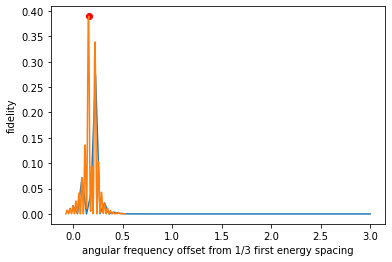

Fidelity Distance: 12.431668
Duration Distance: 0.000000
Frequency Distance: 0.575695


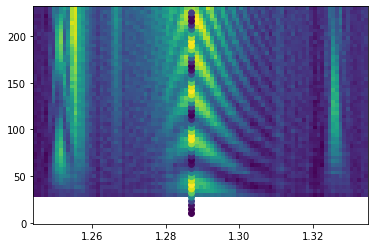

In [17]:
dur_points = np.linspace(10, 225, 50)
freq_points = np.repeat(freq_points[0], 50)
fid_points = []
for i in range(0, len(dur_points)):
    nearest_freq_index = (np.abs(experimental_freqs - freq_points[i])).argmin()
    nearest_dur_index = (np.abs(experimental_time - dur_points[i])).argmin()
    closest_fidelity = normalized_experimental_fids[nearest_freq_index][nearest_dur_index]
    fid_points.append(closest_fidelity)
rr = run_sim(1.5*2*np.pi)

# Generate Fidelity Landscape

In [53]:
from tqdm import tqdm as tqdm
def generate_fidelity_landscape(system, pulse, freq_list, dur_list, t_multiplier=5):
    fids = [] # an array of columns in the landscape
    for freq in tqdm(freq_list):
        fid_column = []
        for dur in dur_list:
            tlist = np.linspace(0, dur, int(dur*t_multiplier))
            pulse.setup(amplitude=pulse._amp, drive_frequency=freq, ramp_slope=ramp_slope, cut_factor=cut_factor, tlist=tlist)
            s = solver.time_evolve(system.H0, system.H1, pulse.pulse_func, tlist, system.starting_state)
            fidelity = expv.expectation_value(s.states[-1], system.target_state)
            fid_column.append(fidelity)
        fids.append(fid_column)

    plt.pcolormesh(freq_list / (2*np.pi), dur_list, np.swapaxes(fids,0,1), shading='auto')
    
    return fids

  0%|          | 0/10 [00:00<?, ?it/s]

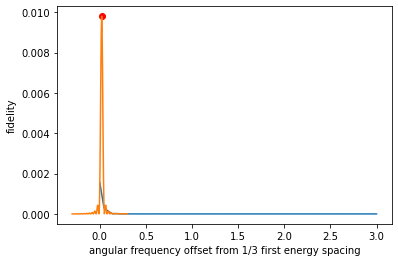

Fidelity Distance: 14.181926
Duration Distance: 0.000000
Frequency Distance: 1.679817


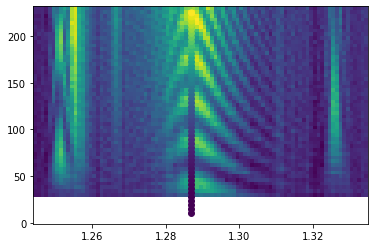

 10%|█         | 1/10 [04:33<41:02, 273.64s/it]

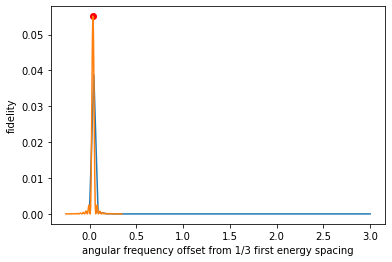

Fidelity Distance: 8.378389
Duration Distance: 0.000000
Frequency Distance: 1.552920


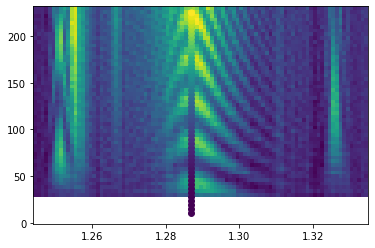

 20%|██        | 2/10 [09:00<35:55, 269.49s/it]

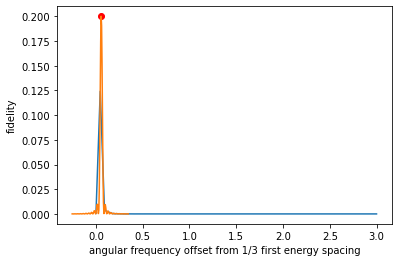

Fidelity Distance: 10.229512
Duration Distance: 0.000000
Frequency Distance: 1.396375


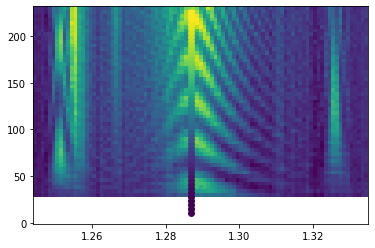

 30%|███       | 3/10 [13:19<30:54, 264.86s/it]

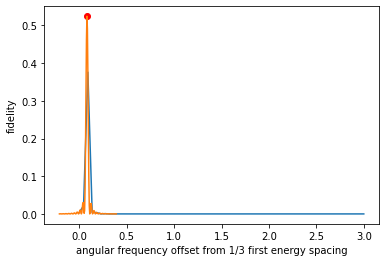

Fidelity Distance: 19.239724
Duration Distance: 0.000000
Frequency Distance: 1.191205


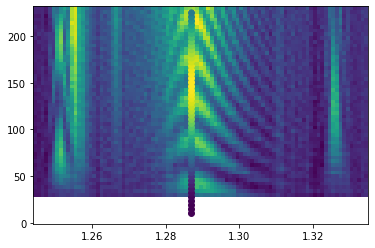

 40%|████      | 4/10 [17:03<24:51, 248.62s/it]

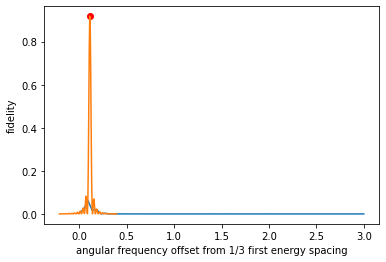

Fidelity Distance: 20.465153
Duration Distance: 0.000000
Frequency Distance: 0.956386


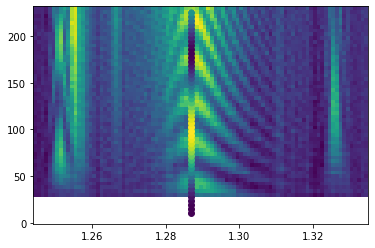

 50%|█████     | 5/10 [20:59<20:19, 243.97s/it]

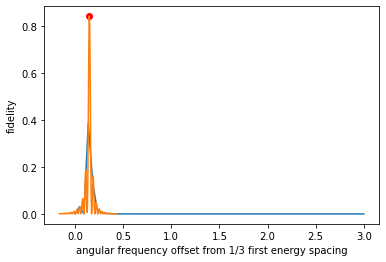

Fidelity Distance: 17.906443
Duration Distance: 0.000000
Frequency Distance: 0.672943


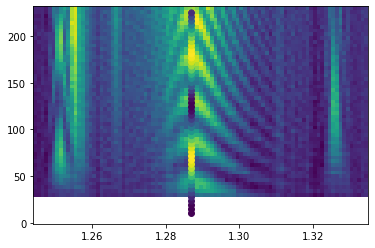

 60%|██████    | 6/10 [24:47<15:54, 238.64s/it]

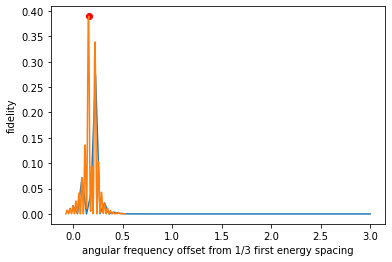

Fidelity Distance: 12.431668
Duration Distance: 0.000000
Frequency Distance: 0.575695


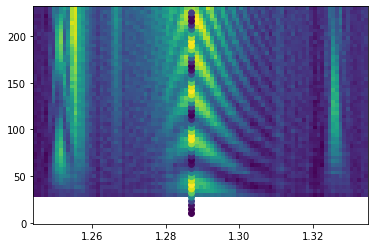

 70%|███████   | 7/10 [28:40<11:50, 236.80s/it]

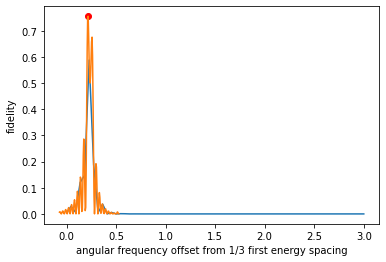

Fidelity Distance: 17.339553
Duration Distance: 0.000000
Frequency Distance: 0.106057


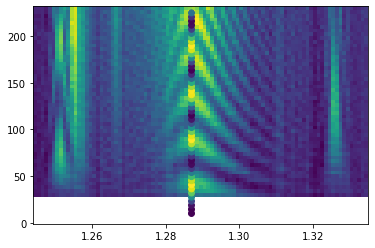

 80%|████████  | 8/10 [32:49<08:01, 240.73s/it]

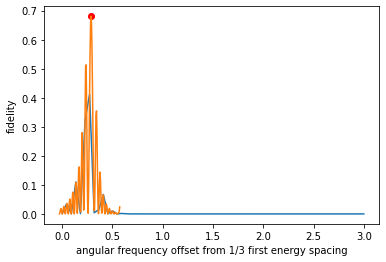

Fidelity Distance: 19.426011
Duration Distance: 0.000000
Frequency Distance: 0.451341


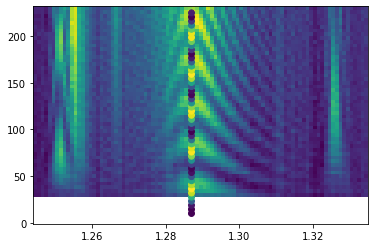

 90%|█████████ | 9/10 [36:49<04:00, 240.62s/it]

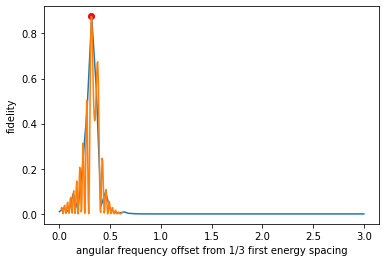

Fidelity Distance: 16.132750
Duration Distance: 0.000000
Frequency Distance: 0.656511


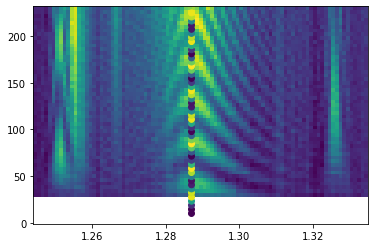

100%|██████████| 10/10 [40:53<00:00, 245.35s/it]


In [18]:
results = []
for amp in tqdm(np.linspace(0.5*2*np.pi, 2*2*np.pi, 10)):
    results.append(run_sim(amp))

  0%|          | 0/4 [00:00<?, ?it/s]

10.681415022205297


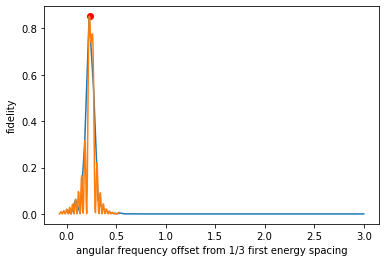

center_offset  0.2321907600596126
Fidelity Distance: 18.823658
Duration Distance: 0.000000
Frequency Distance: 0.011352


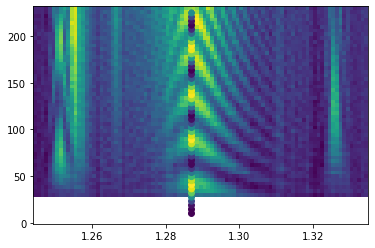

 25%|██▌       | 1/4 [04:24<13:13, 264.35s/it]

11.100294042683936


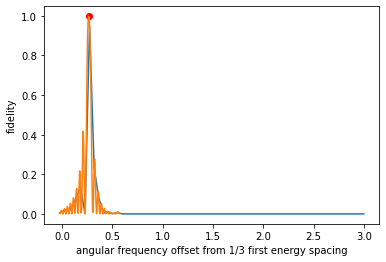

center_offset  0.2628912071535022
Fidelity Distance: 18.214881
Duration Distance: 0.000000
Frequency Distance: 0.255658


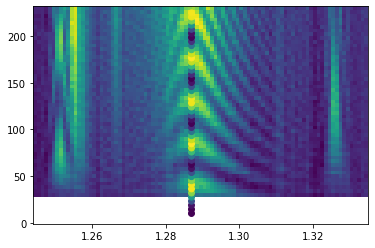

 50%|█████     | 2/4 [08:18<08:13, 246.64s/it]

11.519173063162574


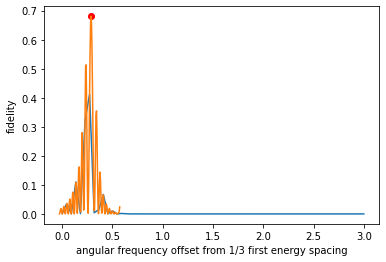

center_offset  0.2874813710879285
Fidelity Distance: 19.426011
Duration Distance: 0.000000
Frequency Distance: 0.451341


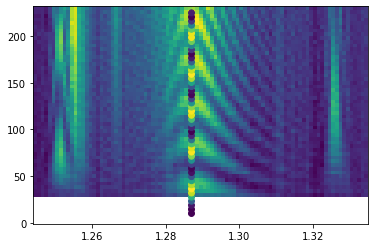

 75%|███████▌  | 3/4 [12:11<04:00, 240.37s/it]

11.938052083641214


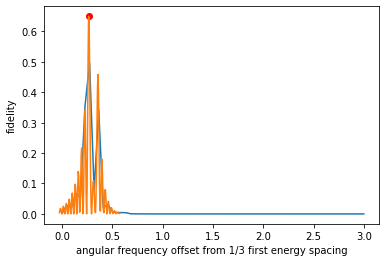

center_offset  0.2628912071535022
Fidelity Distance: 13.103560
Duration Distance: 0.000000
Frequency Distance: 0.255658


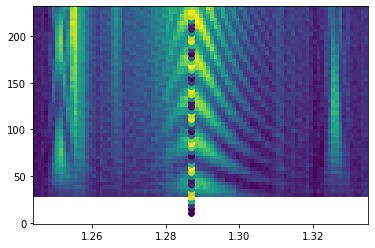

100%|██████████| 4/4 [16:16<00:00, 244.08s/it]


In [26]:
results = []
for amp in tqdm(np.linspace(1.7*2*np.pi, 1.9*2*np.pi, 4)):
    print(amp)
    results.append(run_sim(amp))

100%|██████████| 50/50 [2:13:03<00:00, 159.67s/it]


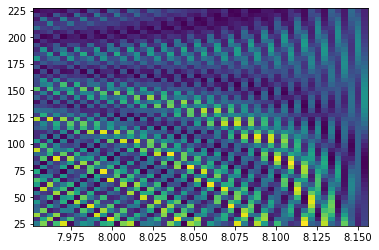

In [33]:
center_offset = 0.2628912071535022
freq_list = system.first_energy_spacing/3 - np.linspace(center_offset-0.1, center_offset+0.1, 50)
dur_list = np.linspace(25, 225, 50)
tanh.setup(11.100294042683936 / (2*np.pi), 0, ramp_slope, cut_factor, dur_list) # just need to have correct amp
stuff = generate_fidelity_landscape(system, tanh, freq_list, dur_list)

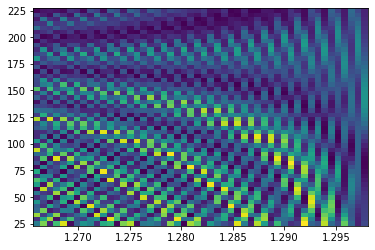

In [42]:
plt.pcolormesh(freq_list / (2*np.pi), dur_list, stuff, shading='auto')

100%|██████████| 50/50 [1:33:32<00:00, 112.26s/it]


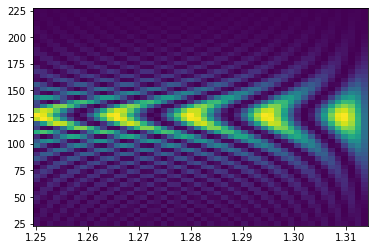

In [43]:
center_offset = 0.2628912071535022
freq_list = system.first_energy_spacing/3 - np.linspace(center_offset-0.2, center_offset+0.2, 50)
dur_list = np.linspace(25, 225, 50)
tanh.setup(11.100294042683936, 0, ramp_slope, cut_factor, dur_list) # just need to have correct amp
stuff2 = generate_fidelity_landscape(system, tanh, freq_list, dur_list, t_multiplier=2)

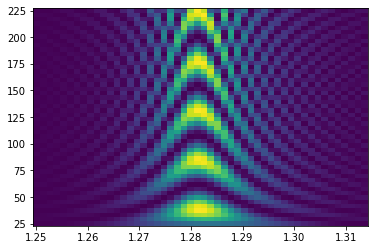

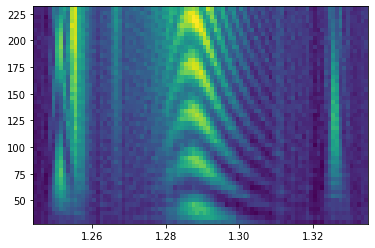

In [50]:
plt.pcolormesh(freq_list / (2*np.pi), dur_list, np.swapaxes(stuff2,0,1), shading='auto')
plt.show()
plt.pcolormesh(experimental_freqs, experimental_time, normalized_experimental_fids, shading='auto')


100%|██████████| 150/150 [49:48:21<00:00, 1195.34s/it]


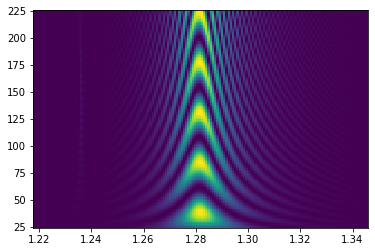

Process ForkPoolWorker-277:
Process ForkPoolWorker-278:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Caskroom/miniforge/base/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/local/Caskroom/miniforge/base/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/local/Caskroom/miniforge/base/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Caskroom/miniforge/base/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Caskroom/miniforge/base/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/local/Caskroom/miniforge/base/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/local/Caskroom/miniforge/base/lib/python3.8/multiprocessing/queues.py", l

In [56]:
center_offset = 0.2628912071535022
freq_list = system.first_energy_spacing/3 - np.linspace(center_offset-0.4, center_offset+0.4, 150)
dur_list = np.linspace(25, 225, 150)
tanh.setup(11.100294042683936, 0, ramp_slope, cut_factor, dur_list) # just need to have correct amp
stuff3 = generate_fidelity_landscape(system, tanh, freq_list, dur_list, t_multiplier=2)

In [62]:
import utils.saver as saver
stuff_to_save = {
    "frequencies": freq_list,
    "durations": dur_list,
    "fidelities": stuff3
}
saver.save_via_pickle(stuff_to_save, "long_run_data")

Text(0, 0.5, 'Pulse Duration (ns)')

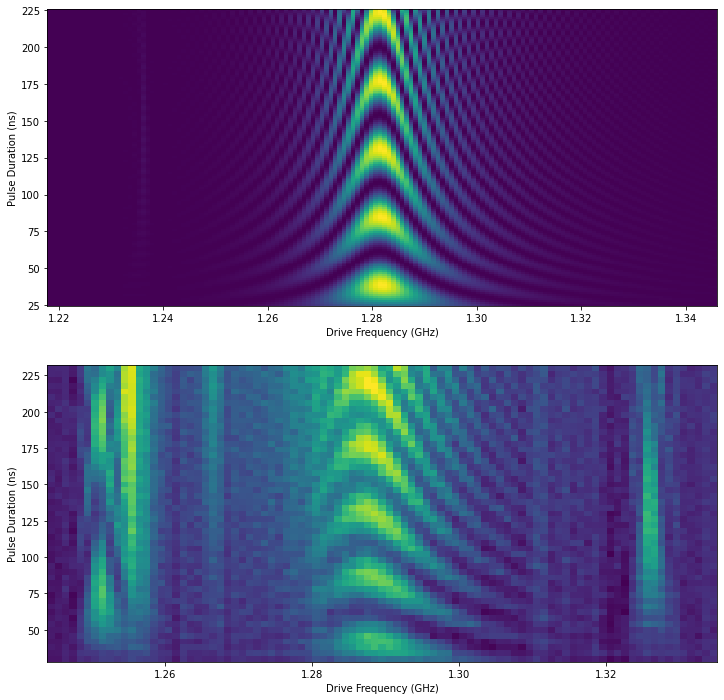

In [77]:
fig, axs = plt.subplots(nrows=2, figsize=(12,12))
axs[0].pcolormesh(freq_list / (2*np.pi), dur_list, np.swapaxes(stuff3,0,1), shading='auto')
# fig.suptitle("Simulation (Amp = 11.1)")
axs[0].set_xlabel("Drive Frequency (GHz)")
axs[0].set_ylabel("Pulse Duration (ns)")
axs[1].pcolormesh(experimental_freqs, experimental_time, normalized_experimental_fids, shading='auto')
axs[1].set_xlabel("Drive Frequency (GHz)")
axs[1].set_ylabel("Pulse Duration (ns)")

Text(0, 0.5, 'Pulse Duration (ns)')

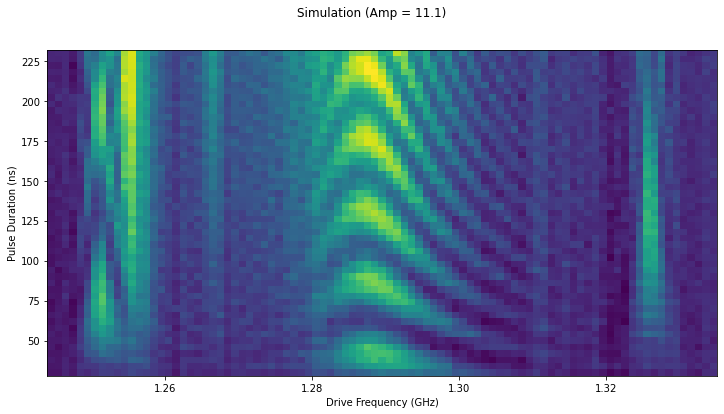

In [72]:
fig, axs = plt.subplots(figsize=(12,6))
plt.pcolormesh(experimental_freqs, experimental_time, normalized_experimental_fids, shading='auto')
fig.suptitle("Simulation (Amp = 11.1)")
axs.set_xlabel("Drive Frequency (GHz)")
axs.set_ylabel("Pulse Duration (ns)")

100%|██████████| 25/25 [36:32<00:00, 87.70s/it]


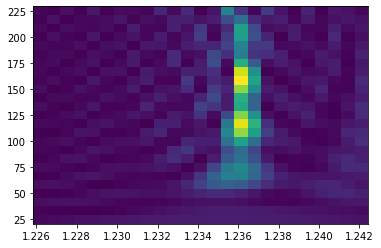

In [86]:
# looking at random thing on the left
center_offset = 0.2628912071535022 + 0.3
freq_list = system.first_energy_spacing/3 - np.linspace(center_offset-0.05, center_offset+0.05, 25)
dur_list = np.linspace(25, 225, 25)
tanh.setup(11.100294042683936, 0, ramp_slope, cut_factor, dur_list) # just need to have correct amp
stuff4 = generate_fidelity_landscape(system, tanh, freq_list, dur_list, t_multiplier=2)

In [ ]:
ramp_slope = 0.5
cut_factor = 3
dur_list = np.linspace(0,170,5000)
tanh.setup(11.100294042683936, 0, ramp_slope, cut_factor, dur_list) # just need to have correct amp
s = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, dur_list, system.starting_state, pbar=True)

graph.graph_solution(s, system)

In [87]:
np.amax(stuff4)

0.03476092457288014

In [85]:
center_offset = 0.2628912071535022
freq_list = system.first_energy_spacing/3 - np.linspace(center_offset-0.2, center_offset+0.2, 40)
dur_list = np.linspace(25, 225, 40)
tanh.setup(11.000294042683936, 0, ramp_slope, cut_factor, dur_list) # just need to have correct amp
stuff5 = generate_fidelity_landscape(system, tanh, freq_list, dur_list, t_multiplier=2)

  5%|▌         | 2/40 [03:18<1:02:53, 99.29s/it]capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
  5%|▌         | 2/40 [03:52<1:13:32, 116.12s/it]


KeyboardInterrupt: 

8.054332499480516


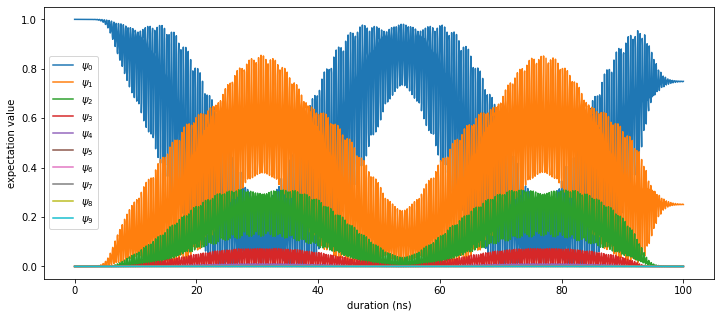

In [15]:
import utils.graph as graph

offset = 0.2628912071535022
freq = system.first_energy_spacing/3 - offset # angular GHz
print(freq)
dur = 100
tlist = np.linspace(0, dur, dur*20)
tanh.setup(11.100294042683936, freq, ramp_slope, cut_factor, tlist) # just need to have correct amp


solution = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, tlist, system.basis_states[0], pbar=True)

graph.graph_solution(solution, system)

# Just a bunch of graphs

In [ ]:
offs = np.linspace(1.26*2*np.pi, 1.31*2*np.pi, 30)
durs = np.linspace(5, 225, 30)

def step(dur):
    tlist = np.linspace(0, dur, int(dur*5))
    tukey.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - _off, ramp_coef=ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=tukey.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expv.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": _off,
        "duration": dur
    }

def sim_graph(amplitude):
    global _amp, _off
    _amp = amplitude
    results = []
    for off in offs:   
        _off = off
        results.append(parfor(step, durs))

    return {
        "amplitude": amplitude,
        "ramp_coef": ramp_coef,
        "results": results
    }

In [ ]:
meta_results = []
for amp in tqdm(np.linspace(1.0*2*np.pi, 3.0*2*np.pi, 10)):
    meta_results.append(sim_graph(amp))

100%|██████████| 10/10 [1:55:39<00:00, 693.96s/it]


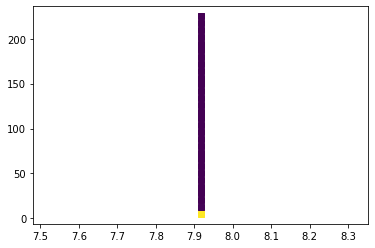

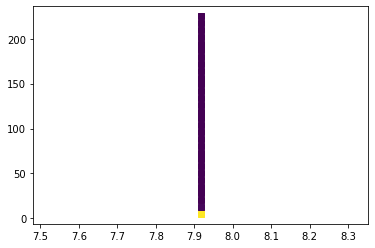

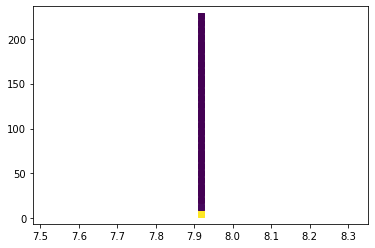

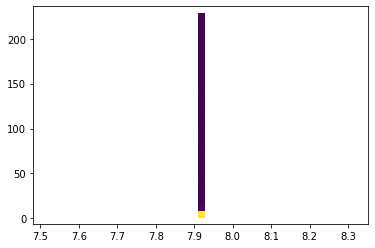

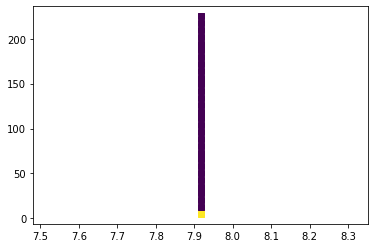

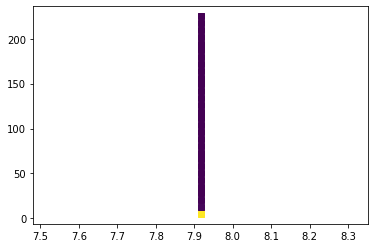

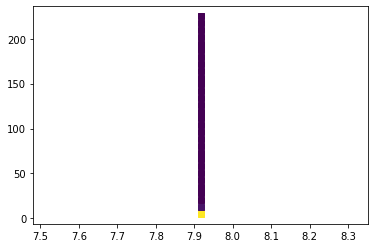

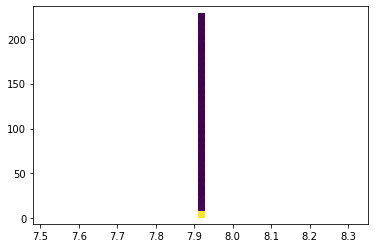

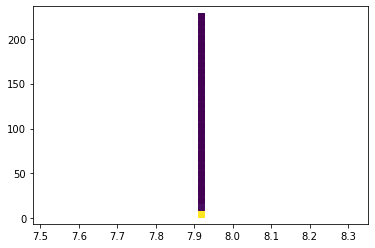

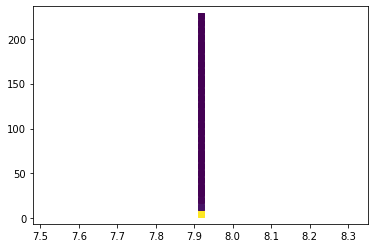

In [ ]:
for result in meta_results:
    offs = []
    durs = []
    fids = []
    for r in result["results"][0]:
        offs.append(r["offset"]) 
        durs.append(r["duration"])
        fids.append(r["fidelity"])

    plt.scatter(offs, durs, c=fids, marker="s")
    plt.show()